In this post I will demonstrate how to use sci-kit learn to classify a landsat image to to burned area and non-burned area. We'll use the downloaded imagery from gogole earth engine and pre-annotated samples from the same area. We will then apply Ranfom Forest classifier to the image and compare the results to the original samples. We will also hyperparameter tune the classifier to get the best results.

In the first step, we import the the necessary libraries and import the data. In my earlier post I have demonstrated how to download a satellite image from GEE. You can follow thatpost to download the image. I have also uploaded the image to my github repository. You can download the image from there as well.

## Importing the packages

In [39]:
# for raster reading
import rasterio
# for vector reading and manipulation
import geopandas as gpd
# for data manipulation
import pandas as pd
# to work with numpy array
import numpy as np

#import scikit learn

import sklearn

## Reading the data files

Read the raster image and the training data

In [40]:
training_path = './BA_training_pixels_2.geojson'
training_pixels = gpd.read_file(training_path)
training_pixels.head()

,class,land_class,geometry
0,13.0,Burned,POINT (739290.000 2659620.000)
1,1.0,Unburned,POINT (730050.000 2650620.000)
2,13.0,Burned,POINT (762240.000 2649120.000)
3,5.0,Burned,POINT (798120.000 2648130.000)
4,4.0,Unburned,POINT (781020.000 2646150.000)


Let's take a look at the distribution of the classes

In [41]:
training_pixels['land_class'].value_counts()

Unburned    447
Burned      253
Name: land_class, dtype: int64

Creating a dictionary with class names and number for later use

In [42]:
classes = np.unique(training_pixels['land_class'])
class_dict = dict(zip(list(classes), range(len(classes))))

class_dict

{'Burned': 0, 'Unburned': 1}

Let's read the raster and check if the both files are in same crs

In [43]:
raster_path = './LT05_145044_20100428_t.tif'
raster = rasterio.open(raster_path)
bands = raster.read()
assert training_pixels.crs == raster.crs , "crs are not the same"

## Visualise the image and overlay the points

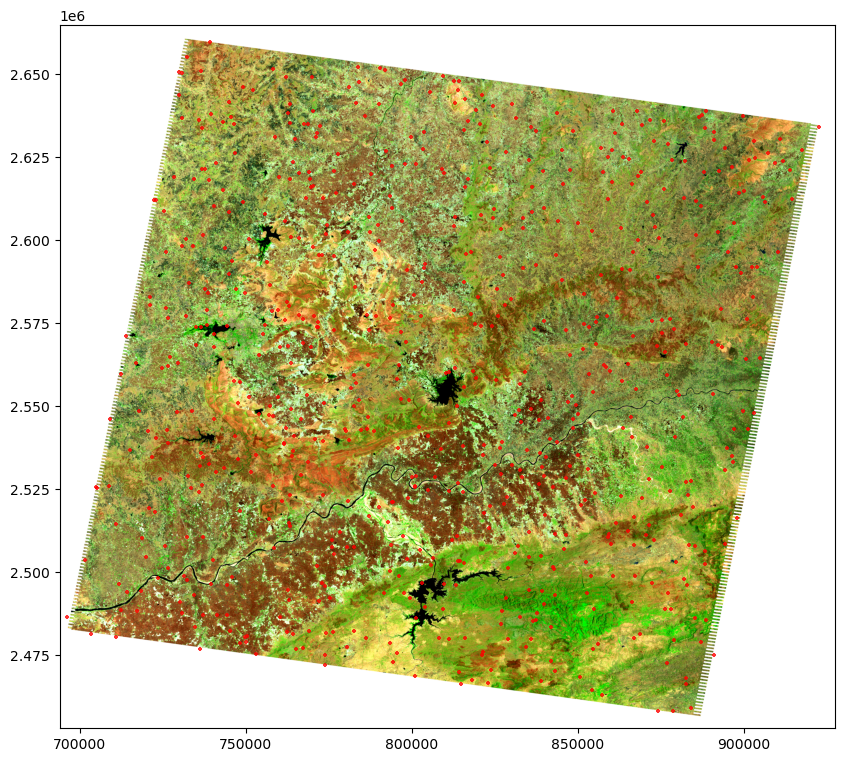

In [44]:
#plt plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
# read the data
#create the rgb bands
rgb  = np.stack((bands[5], bands[3], bands[2]), axis =1)

#expected shape is row, col, index
rgb = np.moveaxis(rgb, 1,2)
rgb.shape

#beofre masking the nan, normlaise the data. it's way easier to do this beofre masking
# especially since you will have to use .dat ato acces and can't modify the masked band

rgb_bands = rgb
# Apply contrast stretching

#get the 2, 98 percentiles for clipping

p2, p98 = np.nanpercentile(rgb_bands, (2, 98))

#clip the values within the range
# every value below 2nd percentile and above 98th percentile will be truncated to the given percentile values
rgb_bands = np.clip(rgb_bands, p2, p98)

#apply the normalisation
rgb_bands = (rgb_bands - p2) / (p98 - p2)

# Create a mask for NaN values
mask = np.isnan(rgb_bands)

## Set the NaN values to white

rgb_bands[mask] = 1.0  # Assuming the range is [0, 1] for color values


# show expect an input with (index, row, col) shape

rgb_masked = np.moveaxis(rgb_bands, -1,0)

from rasterio.plot import show

training_pixels.plot(ax =ax, color = 'red', alpha = .8, markersize = 8, marker = '+')


show(rgb_masked, ax = ax, transform=raster.transform)
plt.show()



## Data Prep

Now that we have trainig labels and the raster image we need the band values for respective points to create the trainig data. For that, we we iterate the points through the raster and save the values of each bands into an arrawy as rows.

We use the latitude and longitude values from the points as an index locate the pixel position  and the respective row, col position in our data arrya. Once we have that information we use that row, col index to extract the values for each pixels across all the bands 

We also use label values from each points and use it to fetch the label number for each points and add it to the repective label dataset.

In [45]:
band_vals =[] 
labels = []

for index, row in training_pixels.iterrows():
    x = row['geometry'].x
    y = row['geometry'].y
    label = row['land_class']
    
    # get the respective row, col
    row, col = raster.index(x,y)

    #get the data for all bands for that pixel
    data = bands[:, row, col]

    # add it to the X
    band_vals.append(data)
    # add the respective label class to y

    labels.append(class_dict[label])

In [46]:
# convert band_vals and labels to full array 

X = np.array(band_vals)

y = np.array(labels)

# check if they have same length

(X.shape, y.shape)


((700, 6), (700,))

In [47]:
# since we have some training data outside the image, we should remove
# otherwise, there will be nan values and the algo won't run

# mask values for the rows with nan
nan_mask = np.any(np.isnan(X), axis =1)

#remove the rows with the mask =TRUE
X = X[~nan_mask]
#apply the same for y
y= y[~nan_mask]

(X.shape, y.shape)

((685, 6), (685,))

split the data to test and train

## Indices

One might ask, why do we need indices if already have those bands in the dataset. Answer is that, indices provide more information and highlight a specific charectersitc of a pixel like vegetatoin,water etc. Thus, providing the algorithm with more patterns leading to improved 

We add NDVI and NDWI. This both will add an indicator for vegetation and moisture and they are helpful since the burned area lack both these characteristics.

NDVI is genrally calculated and normalised difference between NIR and Red band.

NDWI is generally caluclated ad noirmalised difference between NIR and Green Band.

**For Landsat 5**:

NDVI = (Band5- Band4)/(Band 5 + band 4)

NDWI = (Band5 - Band3)/(Band5 - Band3)

We write function that take the arrays and provide an ouput value for each row in an array

In [134]:

# we calculate and use np.expand to add a dimension so that i match with the X which is needed when we add it to the main data

def indice_calc(array_in, band1, band2):
    return np.expand_dims((array_in[:,band1]- array_in[:,band2])/(array_in[:,band1]+ array_in[:,band2]), axis = 1)


ndvi = indice_calc(X,4,3)

ndwi = indice_calc(X, 4,2)

X = np.concatenate([X, ndvi, ndwi], axis =1)


## Model building

In [93]:
from sklearn.model_selection import train_test_split
# we split 80:20 for training and test
# we use stratified split based on the class for balances train and test data


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state =42, stratify = y)

In [94]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((548, 8), (137, 8), (548,), (137,))

Since we don't have equal number of samples for each class we create a dictionary that specifes the relative class distribtion for our data. This would helps the algorithm to reduce the bias.
We obtain the class weights by calculating the reciprocal of the class counts. These weights will assign higher importance to minority classes during model training, helping to mitigate the effects of class imbalance

In [95]:
labels, counts = np.unique(y_train, return_counts = True)
class_weight_dict = dict(zip(labels, 1/counts))
class_weight_dict

{0: 0.005, 1: 0.0028735632183908046}

## Train the model

In [96]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    # number of decision trees
    n_estimators=200,
    class_weight= class_weight_dict,
    # n splits per tree
    max_depth=6,
    #paralisation needed or not
    n_jobs = 1,
    #progress indicator
    verbose =1,
    random_state = 42
)

In [97]:
#fit the model

clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(class_weight={0: 0.005, 1: 0.0028735632183908046},
                       max_depth=6, n_estimators=200, n_jobs=1, random_state=42,
                       verbose=1)

## Predict

In [98]:
preds = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


In [99]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)
cm

array([[39, 11],
       [13, 74]])

In [100]:
#normalised cm
cm.astype('float')/cm.sum(axis =1)[:, np.newaxis]

array([[0.78      , 0.22      ],
       [0.14942529, 0.85057471]])

In [101]:
from sklearn.metrics import precision_score, recall_score

# Assuming `y_true` are the true labels and `y_pred` are the predicted labels

# Calculate precision for a specific class
class_precision = precision_score(y_test, preds, labels=[0], average=None)
print(f"Precision for class {0}: {class_precision}")

# Calculate recall for a specific class
class_recall = recall_score(y_test, preds, labels=[0], average=None)
print(f"Recall for class {0}: {class_recall}")


Precision for class 0: [0.75]
Recall for class 0: [0.78]


## Hyper parameter tuning

before finalisng our model, let's check what combination of the above parameter works best. So we basically check the model performance for each combination of parameters and then pick the combination that produces the best result. We also use crossvalidation, which splits the data into multiple sub-sets and uses each subsets to test the performance 

 We peform this using the scikitlearn functionGridSearchCV to perform grid search with 5 fold cross validation. Finally, we will assess the result and choose the model with the best performance

In remote sensing, we commonly employ overall accuracy, producer's accuracy, and user's accuracy as performance metrics for classification evaluation. These metrics are analogous to accuracy, recall, and precision, respectively, in the field of machine learning. However, in our case, we will utilise the F1 score to compare the performance of different models. The F1 score, which is the harmonic mean of recall and precision, provides a balanced measure of a model's performance.

To address imbalanced sample cases, we specifically utilise the f1_weighted score. This scoring metric takes into account the samples per class when calculating the F1 score. By considering the varying class sizes during evaluation, the f1_weighted score provides a robust assessment of the model's performance, particularly in situations where the dataset has class imbalance.

In [102]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# create a classfier object

clf = RandomForestClassifier(random_state=10, class_weight=class_weight_dict)

#efone the parameter grid to be tested

param_grid = {
    'n_estimators':list(range(100,500,100)),
    'max_depth': [3,5,7],
    # minimum numbee required to split another internal node
    'min_samples_split': [2,4,6]
}

# perfrom grid-search with cross validation
# we choose f1 score to as the metric to compare score

# Create the scorer object using the 'f1_weighted' scoring metric
#scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(clf, param_grid,cv = 5, scoring='f1')
grid_search.fit(X_train, y_train)

# extract the best parameters and best score

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)


Best Parameters: {'max_depth': 7, 'min_samples_split': 6, 'n_estimators': 100}
Best F1 Score: 0.8815090998273677


From this we can see that, 

In [103]:
# we create a new clf with best params
final_clf = RandomForestClassifier(random_state=10, class_weight=class_weight_dict, **best_params)

#fit the model

final_clf.fit(X_train, y_train)

preds_final = final_clf.predict(X_test )

## Confusion matrix

In [104]:
final_cm = confusion_matrix(y_test,preds_final)
final_cm

array([[36, 14],
       [14, 73]])

In [105]:
#normalised cm
final_cm.astype('float')/final_cm.sum(axis =1)[:, np.newaxis]

array([[0.72      , 0.28      ],
       [0.16091954, 0.83908046]])

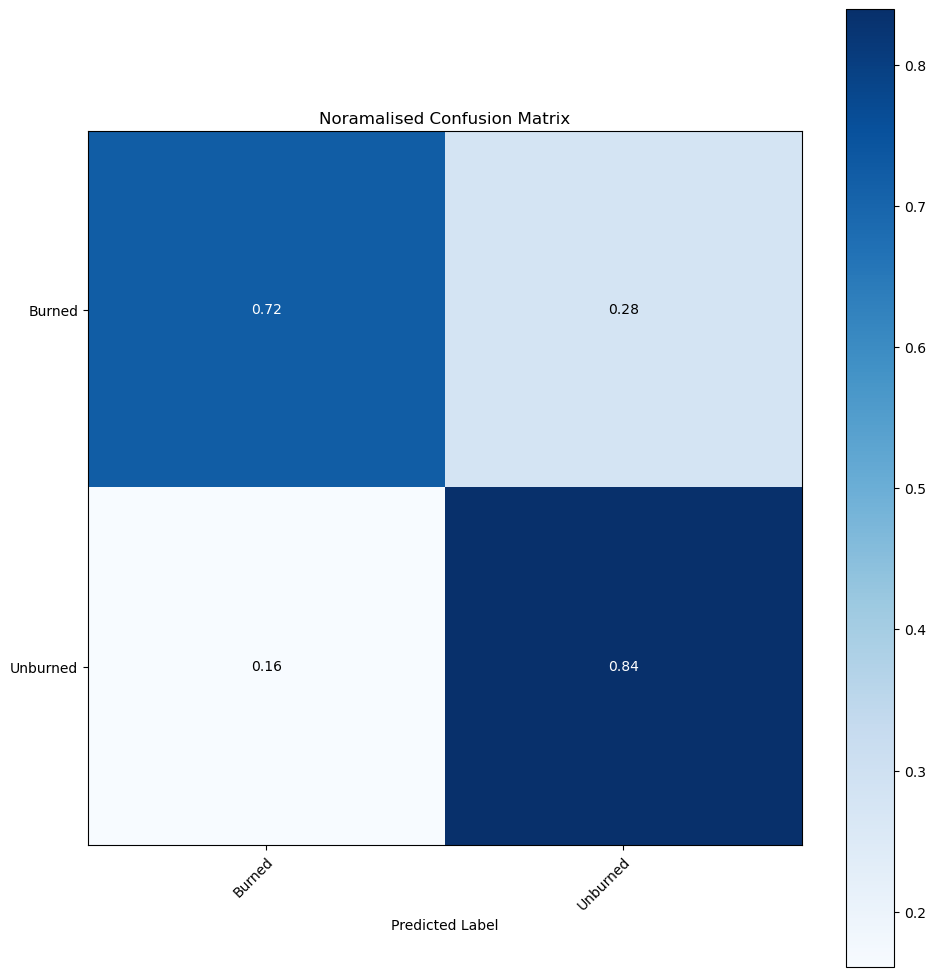

In [106]:
#normalised cm
%matplotlib inline
final_cm = final_cm.astype('float')/final_cm.sum(axis =1)[:, np.newaxis]

fig,ax = plt.subplots(figsize=(10,10))
im= ax.imshow(final_cm, interpolation = 'nearest', cmap = plt.cm.Blues)
ax.figure.colorbar(im, ax = ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks = np.arange(cm.shape[0]),
       #label
       xticklabels = classes, yticklabels = classes,
       title = 'Noramalised Confusion Matrix',
       xlabel = "Predicted Label"
       )

#rotate the labels for alignment

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode = "anchor")
#loop over data dimentions to create tezt annotations

fmt  = '.2f'
thresh = final_cm.max()/2.
for i in range(final_cm.shape[0]):
    for j in range(final_cm.shape[1]):
        ax.text(j,i, format(final_cm[i,j], fmt),
                ha = 'center', va = 'center', color = 'white' if final_cm[i,j] >thresh else "black")
        
fig.tight_layout()

## Predict over the entire image

In this snippet, we use our model to predict over the full image. We are going by small patches to minimise memory use and to avoid crashes. For, that we read our full image and the collect the profile data to write the metadata for  the classified band. We read the bands later by specifying a small patch of the image using window function. Parallel to this we open the image to saved in the write mode and then write onto it window by window. .

Current window is (0, 0)
Current window is (0, 1000)
Current window is (0, 2000)
Current window is (0, 3000)
Current window is (0, 4000)
Current window is (0, 5000)
Current window is (0, 6000)
Current window is (0, 7000)
Current window is (1000, 0)
Current window is (1000, 1000)
Current window is (1000, 2000)
Current window is (1000, 3000)
Current window is (1000, 4000)
Current window is (1000, 5000)
Current window is (1000, 6000)
Current window is (1000, 7000)
Current window is (2000, 0)
Current window is (2000, 1000)
Current window is (2000, 2000)
Current window is (2000, 3000)
Current window is (2000, 4000)
Current window is (2000, 5000)
Current window is (2000, 6000)
Current window is (2000, 7000)
Current window is (3000, 0)
Current window is (3000, 1000)
Current window is (3000, 2000)
Current window is (3000, 3000)
Current window is (3000, 4000)
Current window is (3000, 5000)
Current window is (3000, 6000)
Current window is (3000, 7000)
Current window is (4000, 0)
Current window i

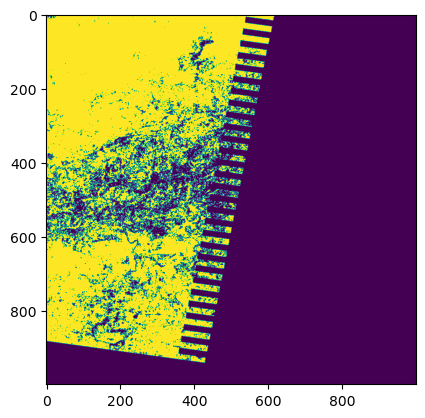

In [224]:
# reading raster windows
# input raster
l5 = raster_path

# output file
output_image = './l5_classified.tif'

# open the full image using rasterio

with rasterio.open(l5, 'r') as src:
    profile = src.profile
    #update profile for the classification ouput
    profile.update(
        # change data type to int
        dtype = rasterio.uint8,
        # specify the band n
        count = 1
    )
    # open the output file in write mode
    with rasterio.open(output_image, 'w', **profile) as dst:

        # specify the patch size
        rows = src.shape[0]//patch_size+1
        cols = src.shape[1]//patch_size+1
        for i in range(rows):
            for j in range(cols):
                window = rasterio.windows.Window(
                    row_off = i * patch_size,
                    col_off = j * patch_size,
                    # adding to ensure this doesn't go out of the image
                    height = min(patch_size, src.shape[0] - i* patch_size),
                    width = min(patch_size, src.shape[1] - j*patch_size)
                )
                print(f"Current window is {window.row_off, window.col_off}")


                # read the window
                data = src.read(window=window)

                # we swap the axis since it get's the masking right
                img_swp = np.moveaxis(data, 0,-1)
                # now we flatten the data to 2-dim array for training
                # -1 will infere the size of first dimension based on second dim, then band size would be used as a the second dim
                img_flat = img_swp.reshape(-1, img_swp.shape[-1]) 
                # let's use indice_cal function to calculte indices

                ndvi = indice_calc(img_flat, 4,3)
                ndwi = indice_calc(img_flat, 4,2)
                # add it to flat data using concat
                img_w_ind = np.concatenate([img_flat, ndvi, ndwi], axis = 1)

                # let's mask the invalid data before training

                mask= np.ma.masked_invalid(img_w_ind)

                # we apply to the data and extract only valid values

                img_masked = img_w_ind[~mask.mask]

                # since it converts the 2d to 1d, we need convert it back again

                to_predict = img_masked.reshape(-1, img_w_ind.shape[-1] )

                # some inputs will be empty especially if you have masked large portions
                # we add a contignecy option to skip that is the case

                if not len(to_predict):
                    continue

                # predict
                # retuns a 1dim array with the predicted classes
                img_pred = final_clf.predict(to_predict)

                # add the data back to the valid pixels using first bands's mask as an index
                # initiate an empty array to store the modified values after masking

                output = np.zeros(img_flat.shape[0])

                output[~mask.mask[:,0]] = img_pred

                # convert to original image dimensions
                # keep in mind that is only 1 band. so we need to give the row,col as an input

                output = output.reshape(*img_swp.shape[:-1])

                # create a final mask for writing
                # so we conver the current mask to image dimensions but only one band
                mask_w = (~mask.mask[:,0].reshape(*img_swp.shape[:-1]))

                #write final files

            

                dst.write(output.astype(rasterio.uint8),1, window = window)

                dst.write_mask(mask, window = window)


            # write the files
plt.imshow(output)



<AxesSubplot:>

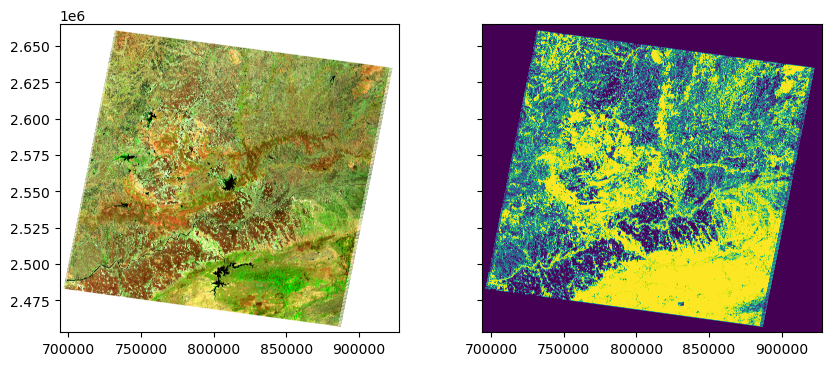

In [225]:
## visualise the image

import matplotlib.pyplot as plt
from rasterio.plot import show
fig,(ax1, ax2) = plt.subplots(ncols =2, nrows= 1,figsize = (10,4), sharey=True)



with rasterio.open('./l5_classified.tif', 'r') as output_raster:
    #show(output_raster)
    classes = output_raster.read()
show(rgb_masked, ax = ax1, transform=raster.transform)
show(classes, transform= output_raster.transform, ax = ax2)
